# Taller 3 - Text Regression
---

En este taller aplicaremos un modelo de perceptrón multicapa en un problema de regresión sobre información textual, usaremos un conjunto de datos sobre la efectividad de distintos medicamentos y comentarios escritos en lenguaje natural:

#### **Integrantes**
- Daniel Andrade (✉ daniel.andrade01@usa.edu.co)
- Dewith Miramón (✉ dewith.miramon01@usa.edu.co)
- Santiago Prado (✉ santiago.prado01@usa.edu.co)

## Carga de Datos
---

Descargamos y cargamos el conjunto de datos con `pandas`:

In [ ]:
# ![[ -f drugs.zip ]] && rm -rf drugs.zip
# !wget 'https://drive.google.com/uc?export=view&id=1T-lZU-4ZjcQ-HQl26b5vj44xVuuejsU3'  -O drugs.zip
# ![[ -f data.csv ]] && rm -rf data.csv
# !unzip drugs.zip -y

In [ ]:
# !pip install wordcloud
# !python -m spacy download en_core_web_sm
# !pip install unidecode
# !pip install ipywidgets --user

In [ ]:
# data
import numpy as np
import pandas as pd
# viz
import matplotlib.pyplot as plt
import seaborn as sns
# nlp
import spacy
from unidecode import unidecode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# utils
# import ipywidgets as widget  <-- Does not work in Deepnote
# widget.IntSlider()
from tqdm.auto import tqdm
tqdm.pandas()

2022-11-03 00:38:09.220707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 00:38:09.345589: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 00:38:09.350502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 00:38:09.350516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [ ]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32165 entries, 0 to 32164
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   patient_id                  32165 non-null  int64  
 1   name_of_drug                32165 non-null  object 
 2   use_case_for_drug           32165 non-null  object 
 3   review_by_patient           32165 non-null  object 
 4   effectiveness_rating        32165 non-null  int64  
 5   drug_approved_by_UIC        32165 non-null  object 
 6   number_of_times_prescribed  32165 non-null  int64  
 7   base_score                  32165 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [ ]:
df.sample(4)

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
27641,28604,Lexapro,Generalized Anxiety Disorde,"""Thank goodness for this medication. I only w...",9,23-Nov-10,32,6.485994
4394,99567,Magnesium sulfate / potassium sulfate / sodium...,Bowel Preparation,"""Finally cracked the code on this:\r\n1) Got S...",7,7-Jul-17,9,6.573013
15330,108,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;ve been on the depo two times now. The...",5,10-Aug-15,10,7.181787
12051,145046,Etonogestrel,Birth Control,"""I had nexplanon for eleven months and all it ...",1,22-Nov-15,3,7.050087


## 1. Análisis Exploratorio
---

Realice un análisis exploratorio sobre los datos para entender el conjunto de datos. Puede aplicar alguna de las siguientes técnicas:

* WordClouds.
* Visualización de la distribución de las variables categóricas.
* Distribución de la longitud de los documentos en el corpus.
* Distribución del número de palabras en los documentos del corpus.

#### Word cloud

In [ ]:
# Cleaning
df.review_by_patient = df.review_by_patient.str.replace('"', '', regex = False)
df.review_by_patient = df.review_by_patient.astype(str)

In [ ]:
text = ' '.join(review for review in df.review_by_patient)
stopwords = set(STOPWORDS)
cloud = WordCloud(stopwords=stopwords, 
                  background_color='white', 
                  max_font_size=50).generate(text)

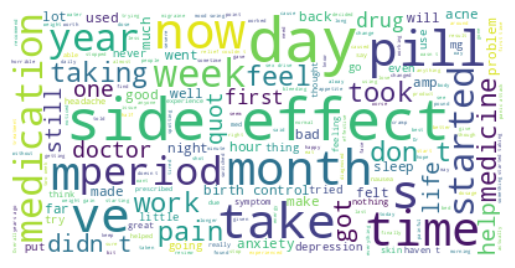

In [ ]:
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Distribution 

In [ ]:
drug_count = df.groupby(by = 'name_of_drug').size().sort_values(ascending=False)
drug_count = drug_count[:25] 

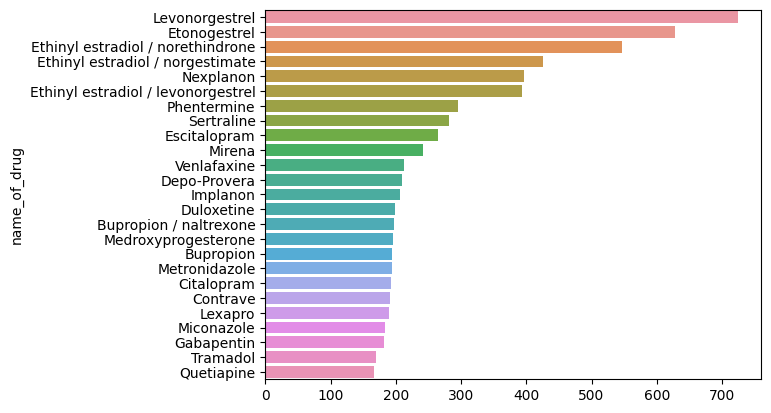

In [ ]:
sns.barplot(x = drug_count.values, y = drug_count.index)
plt.show()

In [ ]:
use_case = df.groupby(by='use_case_for_drug').size().sort_values(ascending=False)
use_case = use_case[:25] 

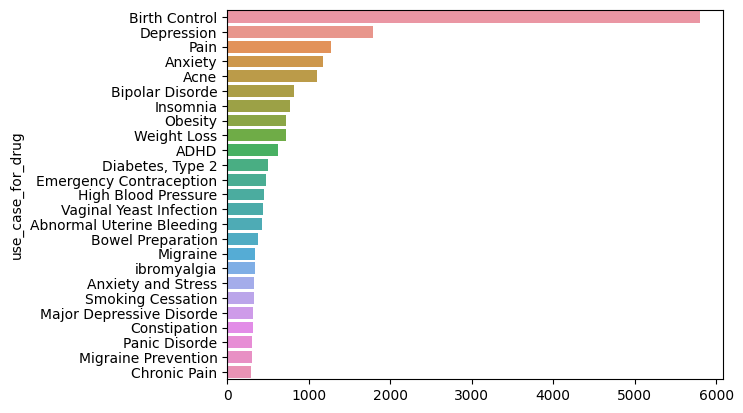

In [ ]:
sns.barplot(x = use_case.values, y =use_case.index)
plt.show()

In [ ]:
df.groupby(by=['use_case_for_drug', 'name_of_drug']).size().sort_values(ascending=False).head(25)

use_case_for_drug        name_of_drug                                          
Birth Control            Etonogestrel                                              626
                         Ethinyl estradiol / norethindrone                         460
                         Levonorgestrel                                            444
                         Nexplanon                                                 396
                         Ethinyl estradiol / levonorgestrel                        352
                         Ethinyl estradiol / norgestimate                          339
Emergency Contraception  Levonorgestrel                                            233
Weight Loss              Phentermine                                               229
Birth Control            Implanon                                                  205
Vaginal Yeast Infection  Miconazole                                                184
Birth Control            Mirena                   

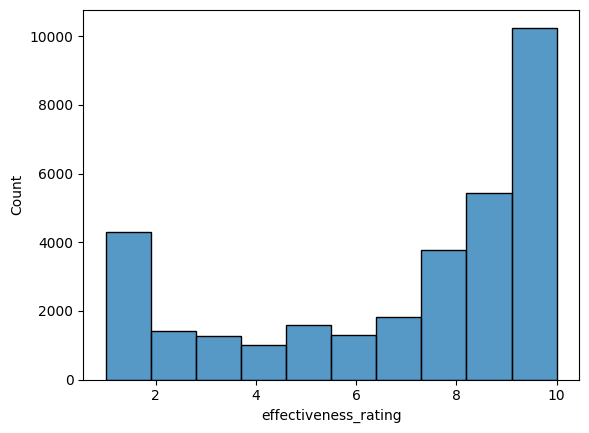

In [ ]:
sns.histplot(data=df, x='effectiveness_rating', bins=10)
plt.show()

In [ ]:
df

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,7.858458
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,6.341969
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,6.590176
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,6.144782
...,...,...,...,...,...,...,...,...
32160,183202,Cymbalta,Anxiety,I have been taking Cymbalta for 15 months now....,9,10-Jun-13,89,6.963020
32161,109111,Nexplanon,Birth Control,"I have had the Nexplanon since Dec. 27, 2016 \...",6,6-Apr-17,0,0.899076
32162,121154,Venlafaxine,Panic Disorde,Had panic attacks and social anxiety starting ...,9,10-Nov-16,25,6.241812
32163,45410,Fluoxetine,Obsessive Compulsive Disorde,I have been off Prozac for about 4 weeks now.....,8,21-Jan-15,22,7.940428


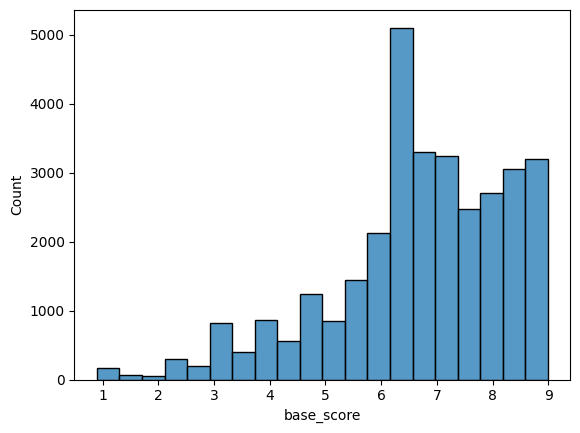

In [ ]:
sns.histplot(data=df, x='base_score', bins=20)
plt.show()

In [ ]:
df['review_len'] = df['review_by_patient'].apply(lambda x: len(x.split()))

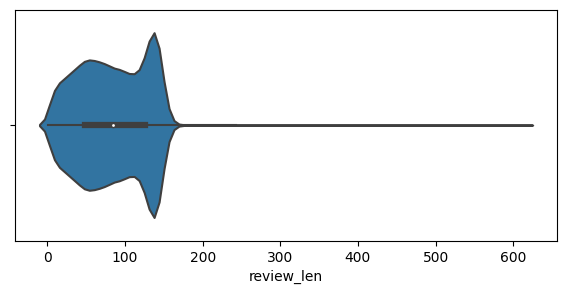

In [ ]:
plt.figure(figsize=(7, 3))
sns.violinplot(data=df, x='review_len')
plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm", exclude=['ner'])

In [ ]:
# for text in df.review_by_patient:
#     doc = nlp(text)

## 2. Preprocesamiento
---

Implemente una función de preprocesamiento para limpiar los documentos del corpus. Recuerde que el texto se encuentra en la columna `review_by_patient`. Puede aplicar técnicas como:

* Tokenizado.
* Normalización de textos (minúsculas, regex, unidecode).
* Eliminación de stopwords.
* Filtrado por longitud de token.
* Stemming o lemmatization.


#### Limpieza y muestreo

In [ ]:
df1 = df.sample(frac=.1, random_state=42).copy()
print('Shape:', df1.shape)

# Further cleaning
df1["review_by_patient"] = (
    df["review_by_patient"]
    .apply(unidecode)
    .str.lower()
    .str.replace('[^a-z0-9]', ' ', regex=True)
    .str.replace(' {2,}', ' ', regex=True)
    .str.strip()
)

Shape: (3216, 9)


#### Tokenizado

In [ ]:
%%time
df1.dropna(subset=["review_by_patient"], inplace=True)
nlp = spacy.load("en_core_web_sm", exclude=['ner'])

df1["review_by_patient_tokenized"] = df1["review_by_patient"].apply(nlp)

CPU times: user 28.4 s, sys: 107 ms, total: 28.5 s
Wall time: 28.6 s


In [ ]:
def remove_stop_words(text_tokens, sw):
    return [word.lemma_ for word in text_tokens 
            if (not word in sw) and (len(word)>2 and len(word)<15)]

In [ ]:
all_stopwords = nlp.Defaults.stop_words
sw_removed_lematized = df1["review_by_patient_tokenized"].apply(
    lambda x: remove_stop_words(x, all_stopwords)
)

In [ ]:
sw_removed_lematized.head()

12551    [could, not, stay, norco, long, term, try, the...
7640     [have, have, problem, with, arthritis, and, de...
24705    [use, this, medication, for, day, for, pep, wh...
27745    [take, bactrim, for, while, now, for, bacteria...
30741    [start, otezla, aftertaste, year, psoriasis, a...
Name: review_by_patient_tokenized, dtype: object

In [ ]:
# with h5py.File("dataset.h5", "w") as f:
#     features_ds = f.create_dataset("features", (200, 96))
#     labels_ds = f.create_dataset("labels", (200, ))
#     features_ds[:] = vectors
#     labels_ds[:] = labels_ord

## 3. Extracción de Características
---

Implemente una estrategia de extracción de características a partir de los textos, algunas estrategias pueden ser:

* Conteos de palabras.
* Word2Vec.
* Representación como tópicos con LSA o LDA.
* Embeddings de `spacy`.

In [ ]:
# Su código aquí

## 4. Validación cruzada
---

Divida los datos en entrenamiento y prueba para validación cruzada, recuerde que la variable objetivo la encuentra como la columna `effectiveness_rating`.

In [ ]:
# Su código aquí

## 5. Creación del DataLoader
---

Cree un `Dataset` y un `DataLoader` de `torch` a partir de las características extraídas de los textos. Debe crear un dataset para train y otro para test.

In [ ]:
# Su código aquí

## 6. Definición del Modelo
---

Cree un perceprón multicapa utilizando `pytorch` o `pytorch-lightning`:

* Debe probar distintos hiperparámetros (número de capas, función de activación, número de neuronas por capa, porcentaje de dropout, entre otros).
* Defina una función de pérdida apropiada para un modelo de regresión.
* Defina un optimizador.

In [ ]:
# Su código aquí

## 7. Entrenamiento
---

Entrene el modelo utilizando el dataloader de train.

In [ ]:
# Su código aquí

## 8. Evaluación
---

Evalúe el desempeño del modelo en el conjunto de datos de test. Debe utilizar métricas apropiadas para un problema de regresión como:

* Error absoluto medio.
* Error cuadrático medio.
* Coeficiente de determinación $r^2$

In [ ]:
# Su código aquí

## 9. Entrega
---

Debe subir su notebook en [este](https://forms.gle/TdjQKC7reXKiWiP26) enlace, pueden trabajar en grupos de máximo 3 personas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c889855d-2c8a-470a-a299-f4199aaed48e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>